# Compare dissimilar queries
Show that CT results indicate extracted factual subject associations important for predicting the traced object. Do this by showing that we measure distinct recall patterns across different factual queries and different traced objects.

In [4]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random
from tqdm import tqdm

#from RQ1.process_data import get_cos_sim

Copied from `RQ1.process_data.py`.

In [5]:
def get_cos_sim(lama_scores, scores):
    if not lama_scores.shape == scores.shape:
        print("Warning: Different shapes of CT results, skipping this sample...")
        return None
    lama_scores = np.nan_to_num(lama_scores/np.linalg.norm(lama_scores, axis=1)[:, np.newaxis])
    scores = np.nan_to_num(scores/np.linalg.norm(scores, axis=1)[:, np.newaxis])
    sim = np.multiply(lama_scores, scores).sum(axis=1)
    return sum(sim)/len(sim)

def get_results_for_token_ix(results, token_ix, answer_for_token):
    results = dict(results)
    results["scores"] = results["scores"][:,:,token_ix]
    results["low_score"] = results["low_score"][token_ix]
    results["high_score"] = results["high_score"][token_ix]
    results["answer"] = answer_for_token #a bit hacky to get the answer as argument
    return results
    
def get_results_for_subject(results):
    # assumes that results already has been filtered by token_id
    results["scores"] = results["scores"][results["subject_range"][0]:results["subject_range"][1],:]
    results["input_tokens"] = results["input_tokens"][results["subject_range"][0]:results["subject_range"][1]]
    results["input_ids"] = results["input_ids"][results["subject_range"][0]:results["subject_range"][1]]
    results["subject_range"] = np.array([0,len(results["input_tokens"])])
    return results

Copied from `similarity_investigations_plot_score.ipynb`

In [6]:
def plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname):
    with plt.rc_context():
        #fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=8)
        cb = plt.colorbar(h, ax=ax)
        cb.ax.tick_params(labelsize=8)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=8)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        #else:
        #    plt.show()
            
def plot_trace_heatmap(result, ax, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    high_score = None #result["high_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname)

In [7]:
relations = ["P19", "P20", "P27", "P101", "P495", "P740", "P1376"]
model_name = "gpt2_xl"

data_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/RQ1"

In [8]:
results_folders = {}
results_folders["P19"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1711765_1815989"
results_folders["P20"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P20/causal_trace_pararel_1906409"
results_folders["P27"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P27/causal_trace_pararel_1910240_P27"
results_folders["P101"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P101/causal_trace_pararel_1883947_P101"
results_folders["P495"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P495/causal_trace_pararel_1883397_P495"
results_folders["P740"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P740/causal_trace_pararel_1883935_P740"
results_folders["P1376"]="/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P1376/causal_trace_pararel_1909054_P1376"

In [9]:
data = pd.DataFrame()

for relation in relations:
    tmp_data = pd.read_csv(os.path.join(data_folder, model_name, f"{relation}.csv"))
    tmp_data["relation"] = relation
    data = data.append(tmp_data, ignore_index=True)
        
data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,4,0,any,P19
1,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,Alexandra,False,False,0.017587,0.003975,False,0.995587,4,2,candidate,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,4,0,any,P19
3,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,Alexandra,False,False,0.017587,0.003594,False,0.996345,4,2,candidate,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63055,1023,1020,Rumbek,{} is the capital of,"{}, the capital city of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.003583,False,0.993998,3,2,candidate,P1376
63056,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",the,the,Lakes,False,False,0.025886,0.025681,True,0.999859,3,0,any,P1376
63057,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.006395,False,0.992868,3,2,candidate,P1376
63058,1025,1020,Rumbek,{} is the capital of,"{}, that is the capital city of",the,the,Lakes,False,False,0.025886,0.051186,True,0.999690,3,0,any,P1376


## Apply the same processing here as for rq1_consistency_similarity_correlation

In [10]:
forbidden_predictions = ["a", "the", "collaboration", "response", "public", '"', "order", "partnership", "honor", "AD", "open", "H", "age", "creating", "disgrace", "her", "his", "in", "left", "not", "providing", "tragedy", "which", "whom"]
forbidden_mask = (data.lama_answer.isin(forbidden_predictions))
data = data[~(forbidden_mask)].reset_index(drop=True)

te_thresh = 0.1
data = data[(data.sample_te>te_thresh) & (data.lama_te>te_thresh)]
print(f"{len(data)} data samples have a TE above 0.1")

5548 data samples have a TE above 0.1


## Make data singleton and not pairwise
Do not need the pairwise comparisons for this stage.

In [11]:
lama_data = pd.DataFrame({"sample_ix": data["lama_ix"], "relation": data["relation"], "subject": data["subject"], "template": data["lama_template"], "answer": data["lama_answer"], "correct_answer": data["correct_answer"], "correct": data["lama_correct"], "te": data["lama_te"], "subj_len": data["subj_len"], "token_ix": data["token_ix"]})
sample_data = pd.DataFrame({"sample_ix": data["sample_ix"], "relation": data["relation"], "subject": data["subject"], "template": data["sample_template"], "answer": data["lama_answer"], "correct_answer": data["correct_answer"], "correct": data["lama_correct"], "te": data["sample_te"], "subj_len": data["subj_len"], "token_ix": data["token_ix"]})

data = pd.concat([lama_data, sample_data], ignore_index=True)
data = data.drop_duplicates() #drop extra lama samples and potential any-candidate duplicates
data.head()

,sample_ix,relation,subject,template,answer,correct_answer,correct,te,subj_len,token_ix
0,280,P19,Parviz Davoodi,{} was born in,Iran,Tehran,False,0.137497,6,0
4,350,P19,Ludwig Marcuse,{} was born in,Vienna,Berlin,False,0.144169,5,0
6,469,P19,Jack Wong Sue,{} was born in,Hong,Perth,False,0.123169,3,0
10,1148,P19,Sergey Lavrov,{} was born in,Moscow,Moscow,True,0.140879,3,0
22,1267,P19,Giulio Romano,{} was born in,Rome,Rome,True,0.137221,5,0


In [12]:
len(data)

4323

In [13]:
pd.set_option('display.min_rows', 1000)
pd.set_option('display.max_rows', 2000)
data.sort_values(["relation", "subject", "template", "answer"])

,sample_ix,relation,subject,template,answer,correct_answer,correct,te,subj_len,token_ix
9181,1322,P101,Aeronautical Information Service,{} works in the area of,aviation,aviation,True,0.100530,6,0
3633,1316,P101,Aeronautical Information Service,{} works in the field of,aviation,aviation,True,0.121244,6,0
9193,1910,P101,Al-Masudi,{} works in the area of,Islamic,history,False,0.114359,4,0
3645,1904,P101,Al-Masudi,{} works in the field of,Islamic,history,False,0.149962,4,0
9197,2379,P101,Alfred Kinsey,{} works in the area of,sexual,biology,False,0.220758,5,0
3649,2373,P101,Alfred Kinsey,{} works in the field of,sexual,biology,False,0.199905,5,0
9204,2491,P101,Australian Mathematical Society,{} works in the area of,mathematics,mathematics,True,0.135806,4,0
3656,2485,P101,Australian Mathematical Society,{} works in the field of,mathematics,mathematics,True,0.261399,4,0
9154,370,P101,Charles Darwin,{} works in the area of,natural,biology,False,0.114717,2,0
3606,364,P101,Charles Darwin,{} works in the field of,natural,biology,False,0.260806,2,0


## Get different subject lengths and counts for these
Need to make comparisons per length.

In [ ]:
sns.histplot(data=data, x="subj_len", bins=30)
plt.show()

In [ ]:
sns.histplot(data=data, x="subj_len", multiple="stack", hue="relation", bins=30)
plt.show()

## Get different subjects and whether they overlap across relations
There are not that many so we will not compare similarities with subject fixed.

In [ ]:
unique_counts = data.groupby("subject").relation.nunique()
unique_counts[unique_counts>1]

## Get different objects and whether they overlap across relations
There are not that many so we will not compare similarities across relations with object fixed.

In [ ]:
unique_counts = data.groupby("answer").relation.nunique()
unique_counts[unique_counts>2]

## Measure similarities between randomly sampled queries 
For different relation-subject-object instances with same subject length.

**Keep relation fixed**
Check variability within relation, still asking for same information. Should still be high.

**Keep object fixed** 
Check variability for same object across subjects and relations (relation maybe not possible). 

**Keep none fixed** 
Full variability across relation-subject-object. 

Across relation-subject-object (none fixed)

In [ ]:
n_samples = 800
np.random.seed(42)

#cos_data = {"ix_1": [], "ix_2": [], "relation_1": [], "relation_2": [], "cos_sim": [], "subj_len": []}
cos_data = []

def get_cos_data_entry(rand_samples):
    entry = {}
    entry["ix_1"] = rand_samples.index[0]
    entry["ix_2"] = rand_samples.index[1]
    entry["relation_1"] = rand_samples.iloc[0].relation
    entry["relation_2"] = rand_samples.iloc[1].relation
    entry["subj_len"] = subj_len

    results = []
    for ix, row in rand_samples.iterrows():
        tmp_res = np.load(os.path.join(results_folders[row.relation], f"cases/{row.sample_ix}_any_mlp.npz"), allow_pickle=True)
        tmp_res = get_results_for_token_ix(tmp_res, row.token_ix, None)
        tmp_res = get_results_for_subject(tmp_res)
        results.append(tmp_res)

    entry["cos_sim"] = get_cos_sim(results[0]["scores"], results[1]["scores"])
    return entry
    
for subj_len in [2,3,4,5,6]:
    for _ in tqdm(range(n_samples)):
        ok_sample = False
        while not ok_sample:
            rand_samples = data[data.subj_len==subj_len].sample(2)
            ok_sample = len(rand_samples.value_counts(["relation", "subject"]))==2

        tmp_entry = get_cos_data_entry(rand_samples)
        tmp_entry["sampling"] = "random"
        cos_data.append(tmp_entry)
        
        #also add for same fact
        rand_sample = data[data.subj_len==subj_len].sample(1)
        samples = pd.concat((rand_sample, 
                             data[(data.relation==rand_sample.iloc[0].relation) & (data.subject==rand_sample.iloc[0].subject) & (data.answer==rand_sample.iloc[0].answer) & ~(data.template==rand_sample.iloc[0].template)].sample()))
        tmp_entry = get_cos_data_entry(samples)
        tmp_entry["sampling"] = "paraphrase"
        cos_data.append(tmp_entry)

cos_data = pd.DataFrame(cos_data)
cos_data

In [ ]:
cos_data.groupby(["subj_len", "sampling"]).cos_sim.agg(["mean", "std", "min", "max"])

In [ ]:
plt.figure(figsize=(4,2))
ax = sns.boxplot(data=cos_data, x="subj_len", y="cos_sim", hue="sampling", linecolor="black", linewidth=0.5, fliersize=4)
plt.xlabel("#subject tokens")
plt.ylabel("Pairwise similarity")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Different fact", "Same fact"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sampled_sim.svg", bbox_inches="tight")
plt.show()

#### Min

In [ ]:
cos_data.groupby("subj_len").cos_sim.min()

In [ ]:
cos_data.loc[cos_data.cos_sim.argmin()]

In [ ]:
data.loc[[10828,10774]]

In [ ]:
cos_ix = 200
row = cos_data.loc[cos_ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
plot_trace_heatmap(res_2, axs[1])
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

#### Max

In [ ]:
cos_data.groupby("subj_len").cos_sim.max()

In [ ]:
cos_data.loc[cos_data.cos_sim.argmax()]

In [ ]:
data.loc[[10434,10083]]

In [ ]:
cos_ix = 408
row = cos_data.loc[cos_ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
plot_trace_heatmap(res_2, axs[1])
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

Can we explain this? 

Examine all cases for which the similarity is above 0.97.

## Keep relation fixed
Examine relations P1376 and P27.

In [ ]:
n_samples = 500
np.random.seed(42)

subj_lens = {"P27": [3,4,5,6], "P1376": [2,3]}

cos_rel_data = {"ix_1": [], "ix_2": [], "relation": [], "cos_sim": [], "subj_len": []}
for relation in ["P27", "P1376"]:
    for subj_len in subj_lens[relation]:
        for _ in tqdm(range(n_samples)):
            ok_sample = False
            while not ok_sample:
                rand_samples = data[(data.subj_len==subj_len) & (data.relation==relation)].sample(2)
                ok_sample = len(rand_samples.value_counts(["relation", "subject"]))==2

            cos_rel_data["ix_1"].append(rand_samples.index[0])
            cos_rel_data["ix_2"].append(rand_samples.index[1])
            cos_rel_data["relation"].append(rand_samples.iloc[0].relation)
            cos_rel_data["subj_len"].append(subj_len)

            results = []
            for ix, row in rand_samples.iterrows():
                tmp_res = np.load(os.path.join(results_folders[row.relation], f"cases/{row.sample_ix}_any_mlp.npz"), allow_pickle=True)
                tmp_res = get_results_for_token_ix(tmp_res, row.token_ix, None)
                tmp_res = get_results_for_subject(tmp_res)
                results.append(tmp_res)

            cos_rel_data["cos_sim"].append(get_cos_sim(results[0]["scores"], results[1]["scores"]))

cos_rel_data = pd.DataFrame(cos_rel_data)
cos_rel_data

In [ ]:
cos_rel_data.groupby(["subj_len"]).cos_sim.agg(["mean", "std", "min", "max"])

In [ ]:
sns.boxplot(data=cos_rel_data, x="subj_len", y="cos_sim", hue="relation")
plt.show()

## Keep object fixed
Can only analyze P27, since it is the only relation with many samples and answers reoccuring across subjects.

In [ ]:
obj_counts = data[(data.subj_len==4) & (data.relation=="P27")].value_counts(["answer", "subject"])
obj_counts[obj_counts>2]

In [ ]:
n_samples = 500
np.random.seed(42)

subj_lens = {"P27": [3,4,5,6]}

cos_rel_obj_data = {"ix_1": [], "ix_2": [], "relation": [], "cos_sim": [], "subj_len": [], "answer": []}
for relation in ["P27"]:
    for subj_len in subj_lens[relation]:
        for _ in tqdm(range(n_samples)):
            ok_sample = False
            while not ok_sample:
                obj_counts = data[(data.subj_len==subj_len) & (data.relation==relation)].answer.value_counts()
                obj = obj_counts[obj_counts>2].sample().index[0]
                rand_samples = data[(data.subj_len==subj_len) & (data.relation==relation) & (data.answer==obj)].sample(2)
                ok_sample = len(rand_samples.value_counts(["relation", "subject"]))==2

            cos_rel_obj_data["ix_1"].append(rand_samples.index[0])
            cos_rel_obj_data["ix_2"].append(rand_samples.index[1])
            cos_rel_obj_data["relation"].append(relation)
            cos_rel_obj_data["answer"].append(obj)
            cos_rel_obj_data["subj_len"].append(subj_len)

            results = []
            for ix, row in rand_samples.iterrows():
                tmp_res = np.load(os.path.join(results_folders[row.relation], f"cases/{row.sample_ix}_any_mlp.npz"), allow_pickle=True)
                tmp_res = get_results_for_token_ix(tmp_res, row.token_ix, None)
                tmp_res = get_results_for_subject(tmp_res)
                results.append(tmp_res)

            cos_rel_obj_data["cos_sim"].append(get_cos_sim(results[0]["scores"], results[1]["scores"]))

cos_rel_obj_data = pd.DataFrame(cos_rel_obj_data)
cos_rel_obj_data

In [ ]:
cos_rel_obj_data.groupby("subj_len").cos_sim.agg(["mean", "std", "min", "max"])

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=cos_rel_obj_data, x="subj_len", y="cos_sim")
plt.show()

In [ ]:
for subj_len in cos_rel_obj_data.subj_len.unique():
    plt.figure(figsize=(10,5))
    sns.boxplot(data=cos_rel_obj_data[cos_rel_obj_data.subj_len==subj_len], x="answer", y="cos_sim")
    plt.title(f"subj_len = {subj_len}")
    plt.xticks(rotation=70)
    plt.show()

# Show that we should examine CT results for all subject tokens

In [ ]:
n_samples = 400
np.random.seed(42)

subj_data = {"ix": [], "relation": [], "subj_len": [], "max_subj_ix": []}
for subj_len in [2,3,4,5,6]:
    rand_samples = data[data.subj_len==subj_len].sample(n_samples)

    subj_data["ix"].extend(list(rand_samples.index))
    subj_data["relation"].extend(list(rand_samples.relation))
    subj_data["subj_len"].extend([subj_len]*n_samples)
        
    for ix, row in rand_samples.iterrows():
        tmp_res = np.load(os.path.join(results_folders[row.relation], f"cases/{row.sample_ix}_any_mlp.npz"), allow_pickle=True)
        tmp_res = get_results_for_token_ix(tmp_res, row.token_ix, None)
        tmp_res = get_results_for_subject(tmp_res)
        subj_data["max_subj_ix"].append(np.argmax(tmp_res["scores"].sum(axis=1))+1)

subj_data = pd.DataFrame(subj_data)
subj_data

In [ ]:
plt.figure(figsize=(4,2))
ax = sns.countplot(data=subj_data, x="subj_len", hue="max_subj_ix", palette="tab10")
plt.xlabel("#subject tokens")
plt.ylabel("#samples")
plt.legend(["1", "2", "3", "4", "5", "6"], title="Subj index")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.99, 1.051))
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/max_subj_ix.svg", bbox_inches="tight")
plt.show()

## Can have distinct patterns for same fact query but different objects 

In [ ]:
answer_counts = data.groupby(["relation", "subject", "template"]).answer.count()
multiple_obj_samples = answer_counts[answer_counts>1]
multiple_obj_samples

In [ ]:
def get_cos_data_entry(rand_samples):
    entry = {}
    entry["ix_1"] = rand_samples.index[0]
    entry["ix_2"] = rand_samples.index[1]
    entry["relation_1"] = rand_samples.iloc[0].relation
    entry["relation_2"] = rand_samples.iloc[1].relation
    entry["subj_len"] = subj_len

    results = []
    for ix, row in rand_samples.iterrows():
        tmp_res = np.load(os.path.join(results_folders[row.relation], f"cases/{row.sample_ix}_any_mlp.npz"), allow_pickle=True)
        tmp_res = get_results_for_token_ix(tmp_res, row.token_ix, None)
        tmp_res = get_results_for_subject(tmp_res)
        results.append(tmp_res)

    entry["cos_sim"] = get_cos_sim(results[0]["scores"], results[1]["scores"])
    return entry

cos_diff_obj_data = []
for ix, _ in multiple_obj_samples.iteritems():
    samples = data[(data.relation==ix[0]) & (data.subject==ix[1]) & (data.template==ix[2])]
    cos_diff_obj_data.append(get_cos_data_entry(samples))

cos_diff_obj_data = pd.DataFrame(cos_diff_obj_data)
cos_diff_obj_data

In [ ]:
ix = 21
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

In [ ]:
ix = 22
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

In [ ]:
ix = 24
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

In [ ]:
ix = 6
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

In [ ]:
ix = 4
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

In [ ]:
ix = 7
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

In [ ]:
ix = 27
row = cos_diff_obj_data.loc[ix]
res_1 = np.load(os.path.join(results_folders[data.loc[row.ix_1].relation], f"cases/{data.loc[row.ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[row.ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[row.ix_2].relation], f"cases/{data.loc[row.ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[row.ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[row.ix_1].template} {data.loc[row.ix_1].answer}")
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[row.ix_2].template} {data.loc[row.ix_2].answer}")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))

## Plot an example pair for the consistency analysis

In [14]:
data[(data.relation=="P101") & (data.subject=="Charles Darwin")]

,sample_ix,relation,subject,template,answer,correct_answer,correct,te,subj_len,token_ix
3606,364,P101,Charles Darwin,{} works in the field of,natural,biology,False,0.260806,2,0
9154,370,P101,Charles Darwin,{} works in the area of,natural,biology,False,0.114717,2,0


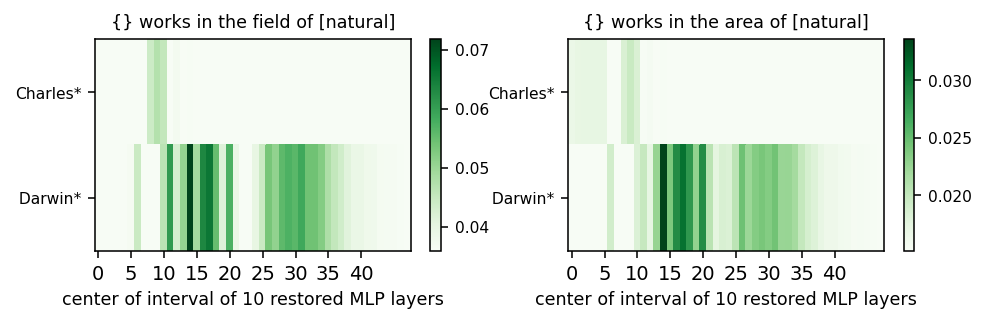

0.9967397451400757


In [25]:
ix_1 = 3606
ix_2 = 9154
res_1 = np.load(os.path.join(results_folders[data.loc[ix_1].relation], f"cases/{data.loc[ix_1].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_1 = get_results_for_token_ix(res_1, data.loc[ix_1].token_ix, None)
res_1 = get_results_for_subject(res_1)

res_2 = np.load(os.path.join(results_folders[data.loc[ix_2].relation], f"cases/{data.loc[ix_2].sample_ix}_any_mlp.npz"), allow_pickle=True)
res_2 = get_results_for_token_ix(res_2, data.loc[ix_2].token_ix, None)
res_2 = get_results_for_subject(res_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
plot_trace_heatmap(res_1, axs[0])
axs[0].set_title(f"{data.loc[ix_1].template} [{data.loc[ix_1].answer}]", fontsize = 9)
axs[0].set_xlabel("center of interval of 10 restored MLP layers", fontsize = 9)
plot_trace_heatmap(res_2, axs[1])
axs[1].set_title(f"{data.loc[ix_2].template} [{data.loc[ix_2].answer}]", fontsize = 9)
axs[1].set_xlabel("center of interval of 10 restored MLP layers", fontsize = 9)
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/example_ct_darwin.svg", bbox_inches="tight")
plt.show()

print(get_cos_sim(res_1["scores"], res_2["scores"]))